In [1]:
%pip install -e /Users/giqks/projects/PhenEx

Obtaining file:///Users/giqks/projects/PhenEx
  Preparing metadata (setup.py) ... done
  DEPRECATION: Legacy editable install of phenex==0.4.0 from file:///Users/giqks/projects/PhenEx (setup.py develop) is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for phenex
Note: you may need to restart the kernel to use updated packages.


In [12]:
import datetime, os
import pandas as pd
import ibis
from phenex.test.cohort_test_generator import CohortTestGenerator
from phenex.codelists import Codelist
from phenex.phenotypes import (
    AgePhenotype,
    CategoricalPhenotype,
    CodelistPhenotype,
    Cohort,
    ContinuousCoveragePhenotype,
    SexPhenotype,
)
from phenex.filters import (
    DateRangeFilter,
    RelativeTimeRangeFilter,
    GreaterThanOrEqualTo,
    GreaterThan,
)
from phenex.tables import PhenexPersonTable, CodeTable, PhenexObservationPeriodTable
from phenex.test.cohort.test_mappings import (
    PersonTableForTests,
    DrugExposureTableForTests,
    ObservationPeriodTableForTests,
    ConditionOccurenceTableForTests,
)


def create_cohort():
    """
    ## DEMO STUDY DEFINITION
    INCLUSION CRITERIA
        * Female patient
        * Aged ≥18 as of the index date
        * Registered in CPRD at least 365 days prior to the index date
        *  At least one drug exposure to ET, defined as a prescription for tamoxifen, aromatase inhibitors (AIs), or gonadotropin releasing hormone (GnRH) antagonists  between 1 January 2010 through 31 December 2020.
    The date of the first ET prescription in this time period is the index date.
    AIs will include: aminoglutethimide, formestane, anastrozole, letrozole, vorozole, exemestane
    GnRH agonists will include: buserelin, leuprorelin/leuprolide, goserelin, triptorelin, histrelin, leuprorelin and bicalutamide, gonadorelin, nafarelin, ganirelix, cetrorelix, elagolix, linzagolix, relugolix, estradiol and norethisterone, degarelix, abarelix
        * BC diagnosis at any time prior to ET prescription in the baseline period
        * Permanently registered acceptable patient

    EXCLUSION CRITERIA
    Any prescription for tamoxifen or AIs before the BC diagnosis date (prevalent users)
    """
    study_period = DateRangeFilter(
        min_date=datetime.date(2010, 1, 1),
        max_date=datetime.date(2020, 12, 31),
    )

    entry = CodelistPhenotype(
        return_date="first",
        codelist=Codelist(["d1"]).resolve(use_code_type=False),
        domain="DRUG_EXPOSURE",
        date_range=study_period,
    )

    inclusion, exclusion = define_inclusion_exclusion_criteria(entry)

    cohort = Cohort(
        name="bc",
        entry_criterion=entry,
        inclusions=inclusion,
        exclusions=exclusion,
    )

    return cohort


def define_inclusion_exclusion_criteria(entry):
    continuous_coverage = ContinuousCoveragePhenotype(
        min_days=GreaterThanOrEqualTo(365), anchor_phenotype=entry
    )

    age_18 = AgePhenotype(min_age=GreaterThanOrEqualTo(18), anchor_phenotype=entry)

    sex = SexPhenotype(allowed_values=[2])

    quality = CategoricalPhenotype(
        allowed_values=[1],
        column_name="ACCEPTABLE",
        domain="PERSON",
        name="data_quality",
    )

    breast_cancer = CodelistPhenotype(
        name="breast_cancer",
        codelist=Codelist(["b1"]).resolve(use_code_type=False),
        domain="CONDITION_OCCURRENCE",
        return_date="first",
        relative_time_range=RelativeTimeRangeFilter(
            when="before", min_days=GreaterThan(0), anchor_phenotype=entry
        ),
    )

    inclusion_criteria = [breast_cancer, continuous_coverage, quality, age_18, sex]

    tamoxifen = CodelistPhenotype(
        name="prior_et_usage",
        codelist=Codelist(["d4", "d5", "d6"]).resolve(use_code_type=False),
        domain="DRUG_EXPOSURE",
        relative_time_range=RelativeTimeRangeFilter(
            anchor_phenotype=breast_cancer,
            when="before",
            min_days=GreaterThan(0),
        ),
    )

    exclusion_criteria = [tamoxifen]

    return inclusion_criteria, exclusion_criteria


from phenex.reporting import InExCounts, Waterfall


class ForJuneCohortRunner:

    def __init__(self):
        pass

    def run_tests(self, path="phenex/test/cohort", verbose=False):
        self.cohort = create_cohort()
        self.mapped_tables = self.define_mapped_tables()
        # THIS IS WHERE THE COHORT IS EXECUTING
        self.cohort.execute(self.mapped_tables)

        ibis.options.interactive = True
        print("INCLUSIONS TABLE")
        print(self.cohort.inclusions_table)

        print("EXCLUSIONS TABLE")
        print(self.cohort.exclusions_table)

        print("INDEX TABLE")
        print(self.cohort.index_table)

        # THIS IS THE TASK!!!! CREATE "UPSET()"
        waterfall_reporter = Waterfall()
        waterfall = waterfall_reporter.execute(self.cohort)
        print(waterfall)


    def define_mapped_tables(self):
        self.con = ibis.duckdb.connect()
        df_allvalues = create_test_data()

        # create dummy person table
        df_person = pd.DataFrame(df_allvalues[["PATID", "YOB", "GENDER", "ACCEPTABLE"]])
        schema_person = {"PATID": str, "YOB": int, "GENDER": int, "ACCEPTABLE": int}
        person_table = PersonTableForTests(
            self.con.create_table("PERSON", df_person, schema=schema_person)
        )

        # create dummy observation period table
        df_observation = pd.DataFrame(df_allvalues[["PATID", "REGSTARTDATE"]])
        df_observation["REGENDDATE"] = datetime.date(2020, 10, 10)
        schema_observation = {
            "PATID": str,
            "REGSTARTDATE": datetime.date,
            "REGENDDATE": datetime.date,
        }
        observation_period_table = ObservationPeriodTableForTests(
            self.con.create_table(
                "OBSERVATION_PERIOD", df_observation, schema=schema_observation
            )
        )

        # create dummy condition occurrence table
        df_condition_occurrence = pd.DataFrame(
            df_allvalues[["PATID", "breast_cancer_code", "breast_cancer_date"]]
        )
        df_condition_occurrence.columns = ["PATID", "MEDCODEID", "OBSDATE"]
        schema_condition_occurrence = {
            "PATID": str,
            "MEDCODEID": str,
            "OBSDATE": datetime.date,
        }
        condition_occurrence_table = ConditionOccurenceTableForTests(
            self.con.create_table(
                "CONDITION_OCCURRENCE",
                df_condition_occurrence,
                schema=schema_condition_occurrence,
            )
        )

        # create drug exposure table
        df_drug_exposure = pd.DataFrame(df_allvalues[["PATID", "entry", "entry_date"]])
        df_drug_exposure.columns = ["PATID", "PRODCODEID", "ISSUEDATE"]
        schema_drug_exposure = {
            "PATID": str,
            "PRODCODEID": str,
            "ISSUEDATE": datetime.date,
        }
        drug_exposure_table = DrugExposureTableForTests(
            self.con.create_table(
                "DRUG_EXPOSURE", df_drug_exposure, schema=schema_drug_exposure
            )
        )

        return {
            "PERSON": person_table,
            "CONDITION_OCCURRENCE": condition_occurrence_table,
            "DRUG_EXPOSURE": drug_exposure_table,
            "OBSERVATION_PERIOD": observation_period_table,
        }


def create_test_data():
    # this is a list of all the parameters i want every possible combination of
    inclusion = [
        {
            "name": "entry",
            "values": ["d1", "d4"],
        },  # the first value is the allowed value, the second is the not allowed value
        {
            "name": "entry_date",
            "values": [datetime.date(2020, 1, 1), datetime.date(2000, 1, 1)],
        },  # first date within study period, second date after
        {"name": "breast_cancer_code", "values": ["b1", "b4"]},
        {
            "name": "breast_cancer_date",
            "values": [datetime.date(2019, 5, 1), datetime.date(2021, 10, 1)],
        },
        {
            "name": "REGSTARTDATE",
            "values": [datetime.date(2018, 1, 1), datetime.date(2019, 10, 1)],
        },  # this is the start date of coverage. i will manually sett index date (date of entry) as 2020.01.01. cc callculated from there. end date similarly a date after index date
        {"name": "ACCEPTABLE", "values": [1, 0]},
        {"name": "YOB", "values": [1970, 2010]},
        {"name": "GENDER", "values": [2, 1]},
        # {"name":"prior_et_use", "values":['d7','d5']},
    ]

    # create the dataframe with two rows; first patient fulfills entry criteria, second does not
    item = inclusion[0]
    df = pd.DataFrame()
    df[item["name"]] = item["values"]

    # iterate over each following criteria, duplicating the previous values
    for item in inclusion[1:]:
        _dfs = []
        for value in item["values"]:
            _df = pd.DataFrame(df)
            _df[item["name"]] = value
            _dfs.append(_df)
        df = pd.concat(_dfs)
    # create appropriate patient ids. only patient 0 fulfills all criteria!
    df["PATID"] = [f"P{i}" for i in range(df.shape[0])]
    return df



cprd_study = ForJuneCohortRunner()
cprd_study.run_tests()






2025-04-01 15:03:30,479 - phenex.phenotypes.cohort - INFO - Cohort 'bc' initialized with entry criterion 'None'
2025-04-01 15:03:30,594 - phenex.phenotypes.cohort - INFO - Executing cohort 'bc' with 1 threads...
2025-04-01 15:03:30,595 - phenex.phenotypes.cohort - DEBUG - Computing entry criterion ...
2025-04-01 15:03:30,595 - phenex.phenotypes.phenotype - INFO - Phenotype 'None': executing...
2025-04-01 15:03:30,610 - phenex.phenotypes.phenotype - INFO - Phenotype 'None': execution completed.
2025-04-01 15:03:30,610 - phenex.phenotypes.cohort - DEBUG - Entry criterion computed.
2025-04-01 15:03:30,621 - phenex.phenotypes.cohort - DEBUG - Applying inclusions ...
2025-04-01 15:03:30,621 - phenex.phenotypes.cohort - DEBUG - Computing inclusions table
2025-04-01 15:03:30,621 - phenex.phenotypes.cohort - DEBUG - Computing inex table
2025-04-01 15:03:30,623 - phenex.phenotypes.phenotype - INFO - Phenotype 'breast_cancer': executing...
2025-04-01 15:03:30,624 - phenex.phenotypes.phenotype - 

INCLUSIONS TABLE


┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━
┃ PERSON_ID ┃ breast_cancer_BOOLEAN ┃ continuous_coverage_BOOLEAN ┃ data_quality_BOOLEAN ┃ age_BOOLEAN ┃ sex_BOOLEA
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━
│ string    │ boolean               │ boolean                     │ boolean              │ boolean     │ boolean   
├───────────┼───────────────────────┼─────────────────────────────┼──────────────────────┼─────────────┼───────────
│ P0        │ True                  │ True                        │ True                 │ True        │ True      
│ P4        │ False                 │ True                        │ True                 │ True        │ True      
│ P12       │ False                 │ True                        │ True                 │ True        │ True      
│ P8        │ False                 │ True                        │ True

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ PERSON_ID ┃ prior_et_usage_BOOLEAN ┃ BOOLEAN ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ string    │ boolean                │ boolean │
├───────────┼────────────────────────┼─────────┤
│ P136      │ False                  │ False   │
│ P180      │ False                  │ False   │
│ P252      │ False                  │ False   │
│ P56       │ False                  │ False   │
│ P100      │ False                  │ False   │
│ P248      │ False                  │ False   │
│ P48       │ False                  │ False   │
│ P36       │ False                  │ False   │
│ P112      │ False                  │ False   │
│ P120      │ False                  │ False   │
│ …         │ …                      │ …       │
└───────────┴────────────────────────┴─────────┘
INDEX TABLE


2025-04-01 15:03:31,355 - phenex.reporting.waterfall - DEBUG - Beginning execution of waterfall. Calculating N patents


┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┓
┃ PERSON_ID ┃ BOOLEAN ┃ EVENT_DATE ┃ VALUE   ┃
┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━┩
│ string    │ boolean │ date       │ float64 │
├───────────┼─────────┼────────────┼─────────┤
│ P0        │ True    │ 2020-01-01 │    NULL │
└───────────┴─────────┴────────────┴─────────┘


2025-04-01 15:03:31,614 - phenex.reporting.waterfall - DEBUG - Cohort has 1 patients
2025-04-01 15:03:31,652 - phenex.reporting.waterfall - DEBUG - Starting inclusion criteria breast_cancer
2025-04-01 15:03:31,757 - phenex.reporting.waterfall - DEBUG - Finished inclusion criteria breast_cancer: N = 16 waterfall = 16
2025-04-01 15:03:31,759 - phenex.reporting.waterfall - DEBUG - Starting inclusion criteria continuous_coverage
2025-04-01 15:03:31,910 - phenex.reporting.waterfall - DEBUG - Finished inclusion criteria continuous_coverage: N = 32 waterfall = 8
2025-04-01 15:03:31,913 - phenex.reporting.waterfall - DEBUG - Starting inclusion criteria data_quality
2025-04-01 15:03:32,048 - phenex.reporting.waterfall - DEBUG - Finished inclusion criteria data_quality: N = 32 waterfall = 4
2025-04-01 15:03:32,051 - phenex.reporting.waterfall - DEBUG - Starting inclusion criteria age
2025-04-01 15:03:32,216 - phenex.reporting.waterfall - DEBUG - Finished inclusion criteria age: N = 32 waterfall 

           type                 name     N  waterfall  delta
0         entry                 None  64.0         64    NaN
1     inclusion        breast_cancer  16.0         16  -48.0
2     inclusion  continuous_coverage  32.0          8   -8.0
3     inclusion         data_quality  32.0          4   -4.0
4     inclusion                  age  32.0          2   -2.0
5     inclusion                  sex  32.0          1   -1.0
6     exclusion       prior_et_usage   0.0          1    0.0
7  final_cohort          index_table   NaN          1    NaN


In [13]:
cprd_study.cohort.inclusions_table

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ PERSON_ID ┃ breast_cancer_BOOLEAN ┃ continuous_coverage_BOOLEAN ┃ data_quality_BOOLEAN ┃ age_BOOLEAN ┃ sex_BOOLEAN ┃ BOOLEAN ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━┩
│ string    │ boolean               │ boolean                     │ boolean              │ boolean     │ boolean     │ boolean │
├───────────┼───────────────────────┼─────────────────────────────┼──────────────────────┼─────────────┼─────────────┼─────────┤
│ P8        │ False                 │ True                        │ True                 │ True        │ True        │ False   │
│ P12       │ False                 │ True                        │ True                 │ True        │ True        │ False   │
│ P0        │ True                  │ True                        │ True                 │ True        │ True        │ True    │
│ P4        │ False                 │ True                        │ True                 │ True        │ True        │ False   │
│ P20       │ False                 │ False                       │ True                 │ True        │ True        │ False   │
│ P24       │ False                 │ False                       │ True                 │ True        │ True        │ False   │
│ P28       │ False                 │ False                       │ True                 │ True        │ True        │ False   │
│ P16       │ True                  │ False                       │ True                 │ True        │ True        │ False   │
│ P36       │ False                 │ True                        │ False                │ True        │ True        │ False   │
│ P32       │ True                  │ True                        │ False                │ True        │ True        │ False   │
│ …         │ …                     │ …                           │ …                    │ …           │ …           │ …       │
└───────────┴───────────────────────┴─────────────────────────────┴──────────────────────┴─────────────┴─────────────┴─────────┘

In [86]:
cprd_study.cohort.exclusions_table

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ PERSON_ID ┃ prior_et_usage_BOOLEAN ┃ BOOLEAN ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ string    │ boolean                │ boolean │
├───────────┼────────────────────────┼─────────┤
│ P220      │ False                  │ False   │
│ P116      │ False                  │ False   │
│ P132      │ False                  │ False   │
│ P148      │ False                  │ False   │
│ P172      │ False                  │ False   │
│ P32       │ False                  │ False   │
│ P204      │ False                  │ False   │
│ P144      │ False                  │ False   │
│ P128      │ False                  │ False   │
│ P168      │ False                  │ False   │
│ …         │ …                      │ …       │
└───────────┴────────────────────────┴─────────┘

In [11]:
class Animal:
    def __init__(self, type, sound):
        print("Hi Animal")
        self.type=type
        self.sound=sound

    def make_a_sound(self):
        print("I am a", self.type, self.sound)

flamingo=Animal("flamingo", "quark")
flamingo.make_a_sound()
flamingo.type
        

Hi Animal
I am a flamingo quark


'flamingo'

/opt/homebrew/anaconda3/envs/phenex/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/opt/homebrew/anaconda3/envs/phenex/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["l

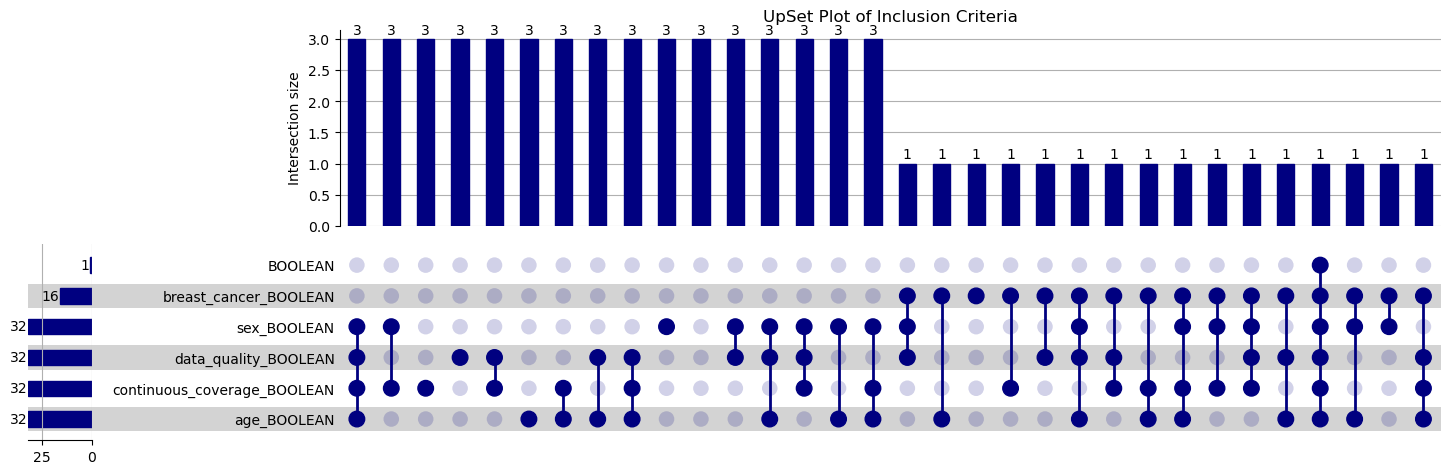

In [187]:
import pandas as pd
from upsetplot import UpSet
from upsetplot import from_memberships
import matplotlib.pyplot as plt

class UpSetPlot:
    """
    A class to prepare data for an UpSet plot by performing inner joins on inclusion and exclusion tables.
    
    Attributes:
        inclusions_table : DataFrame containing inclusion criteria data with boolean columns.
        exclusions_table : DataFrame containing exclusion criteria data with boolean columns.
    """

    def execute(self, cohort: "Cohort") -> pd.DataFrame:
        
        """
        Execute the process to prepare data for the UpSet plot.
        """

        self.cohort = cohort
        self.inclusions_table = self.cohort.inclusions_table
        criteria_dict = {}

            
         # Get the boolean columns
        criteria_columns = [col for col in self.inclusions_table.columns if col != 'PERSON_ID']
    

        # Generate the membership dictionary
        for row in self.inclusions_table.to_pandas().itertuples(index=False):
            patient_id = row.PERSON_ID
        # Get the criteria names where the value is True
            criteria = [col for col in criteria_columns if getattr(row, col)]  # Exclude 'id' and get criteria columns
            criteria_dict[patient_id] = criteria
        
        criteria_list_of_lists= list(criteria_dict.values())

        self.prepared_data=from_memberships(criteria_list_of_lists)

        return self.prepared_data


    def plot_upset(self):
        """
        Generate the UpSet plot.
        """
        if self.prepared_data is None:
            raise ValueError("No prepared data available. Please run execute() first.")
            
        upset = UpSet(self.prepared_data, subset_size='count',  facecolor="navy", shading_color="lightgray", show_counts='%d', sort_by='cardinality')
        upset.plot()
        plt.title("UpSet Plot of Inclusion Criteria")
        plt.show()


# Create an instance of UpSetDataPrep
upset_data_prep = UpSetPlot()

# Execute the data preparation and plot the UpSet
upset_data_prep.execute(cprd_study.cohort)
upset_data_prep.plot_upset()

In [143]:
# Prepare the membership data using Ibis
def prepare_criteria_dict(inclusions_table):
    # Create a dictionary to hold membership information
    criteria_dict = {}

    # Get the boolean columns
    criteria_columns = [col for col in inclusions_table.columns if col != 'PERSON_ID']

    # Generate the membership dictionary
    for row in inclusions_table.execute().itertuples(index=False):
        patient_id = row.PERSON_ID
        # Get the criteria names where the value is True
        criteria = [col for col in criteria_columns if getattr(row, col)]  # Exclude 'id' and get criteria columns
        criteria_dict[patient_id] = criteria

    return criteria_dict

    
# Get the criteria dictionary
criteria_dict = prepare_criteria_dict(cprd_study.cohort.inclusions_table)

criteria_list_of_lists = list(criteria_dict.values())

# Print the results
print(criteria_list_of_lists
     )

[['breast_cancer_BOOLEAN', 'continuous_coverage_BOOLEAN', 'data_quality_BOOLEAN', 'age_BOOLEAN', 'sex_BOOLEAN', 'BOOLEAN'], ['continuous_coverage_BOOLEAN', 'data_quality_BOOLEAN', 'age_BOOLEAN', 'sex_BOOLEAN'], ['continuous_coverage_BOOLEAN', 'data_quality_BOOLEAN', 'age_BOOLEAN', 'sex_BOOLEAN'], ['continuous_coverage_BOOLEAN', 'data_quality_BOOLEAN', 'age_BOOLEAN', 'sex_BOOLEAN'], ['data_quality_BOOLEAN', 'age_BOOLEAN', 'sex_BOOLEAN'], ['breast_cancer_BOOLEAN', 'data_quality_BOOLEAN', 'age_BOOLEAN', 'sex_BOOLEAN'], ['data_quality_BOOLEAN', 'age_BOOLEAN', 'sex_BOOLEAN'], ['data_quality_BOOLEAN', 'age_BOOLEAN', 'sex_BOOLEAN'], ['breast_cancer_BOOLEAN', 'continuous_coverage_BOOLEAN', 'age_BOOLEAN', 'sex_BOOLEAN'], ['continuous_coverage_BOOLEAN', 'age_BOOLEAN', 'sex_BOOLEAN'], ['continuous_coverage_BOOLEAN', 'age_BOOLEAN', 'sex_BOOLEAN'], ['continuous_coverage_BOOLEAN', 'age_BOOLEAN', 'sex_BOOLEAN'], ['age_BOOLEAN', 'sex_BOOLEAN'], ['age_BOOLEAN', 'sex_BOOLEAN'], ['age_BOOLEAN', 'sex_BOOL

In [145]:

final1=from_memberships(criteria_list_of_lists)
final1



/opt/homebrew/anaconda3/envs/phenex/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


BOOLEAN  age_BOOLEAN  breast_cancer_BOOLEAN  continuous_coverage_BOOLEAN  data_quality_BOOLEAN  sex_BOOLEAN
True     True         True                   True                         True                  True           1
False    True         False                  True                         True                  True           1
                                                                                                True           1
                                                                                                True           1
                                             False                        True                  True           1
                                                                                                              ..
         False        False                  True                         False                 False          1
                      True                   False                        False                 False

/opt/homebrew/anaconda3/envs/phenex/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/opt/homebrew/anaconda3/envs/phenex/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

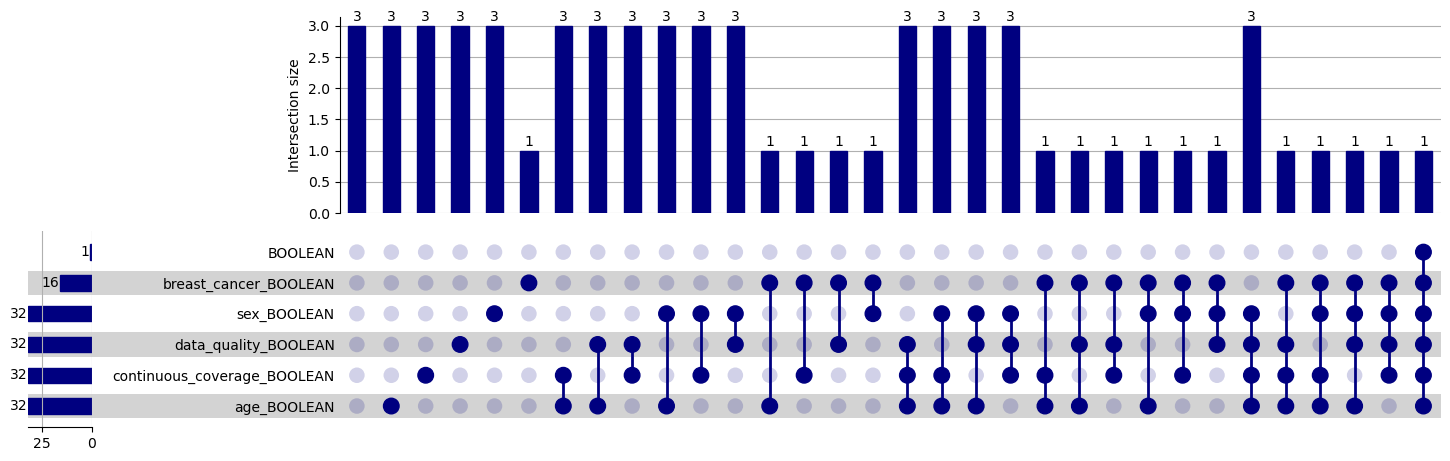

In [151]:
upset = UpSet(final1, subset_size='count',  facecolor="navy", shading_color="lightgray", show_counts='%d')
upset.plot()